In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf


def tf_xavier_init(fan_in, fan_out, *, const=1.0, dtype=np.float32):
    k = const * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval=-k, maxval=k, dtype=dtype)


def sample_bernoulli(probs):
    return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))


def sample_gaussian(x, sigma):
    return x + tf.random_normal(tf.shape(x), mean=0.0, stddev=sigma, dtype=tf.float32)

Using TensorFlow backend.


In [0]:


trainx = np.genfromtxt("/trainafter.csv", delimiter=",")
trainy = np.genfromtxt("/trainlabel.csv", delimiter=",")

# Convert labels to binary since we will use a softmax output
print(trainy)

data = trainx

[1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]


In [0]:


testx = np.genfromtxt("/test.csv", delimiter=",")
testy = np.genfromtxt("/testlabel.csv", delimiter=",")
#testy = np.argmax(testy,axis=1)

print(classification_report(testy, logreg.predict(testx)))

              precision    recall  f1-score   support

         0.0       0.53      0.56      0.55        41
         1.0       0.51      0.49      0.50        39

    accuracy                           0.53        80
   macro avg       0.52      0.52      0.52        80
weighted avg       0.52      0.53      0.52        80



In [0]:
class GBRBM(RBM):
    def __init__(self, n_visible, n_hidden, sample_visible=False, sigma=1, **kwargs):
        self.sample_visible = sample_visible
        self.sigma = sigma

        RBM.__init__(self, n_visible, n_hidden, **kwargs)

    def _initialize_vars(self):
        hidden_p = tf.nn.sigmoid(tf.matmul(self.x, self.w) + self.hidden_bias)
        visible_recon_p = tf.matmul(sample_bernoulli(hidden_p), tf.transpose(self.w)) + self.visible_bias

        if self.sample_visible:
            visible_recon_p = sample_gaussian(visible_recon_p, self.sigma)

        hidden_recon_p = tf.nn.sigmoid(tf.matmul(visible_recon_p, self.w) + self.hidden_bias)

        positive_grad = tf.matmul(tf.transpose(self.x), hidden_p)
        negative_grad = tf.matmul(tf.transpose(visible_recon_p), hidden_recon_p)

        def f(x_old, x_new):
            return self.momentum * x_old +\
                   self.learning_rate * x_new * (1 - self.momentum) / tf.to_float(tf.shape(x_new)[0])

        delta_w_new = f(self.delta_w, positive_grad - negative_grad)
        delta_visible_bias_new = f(self.delta_visible_bias, tf.reduce_mean(self.x - visible_recon_p, 0))
        delta_hidden_bias_new = f(self.delta_hidden_bias, tf.reduce_mean(hidden_p - hidden_recon_p, 0))

        update_delta_w = self.delta_w.assign(delta_w_new)
        update_delta_visible_bias = self.delta_visible_bias.assign(delta_visible_bias_new)
        update_delta_hidden_bias = self.delta_hidden_bias.assign(delta_hidden_bias_new)

        update_w = self.w.assign(self.w + delta_w_new)
        update_visible_bias = self.visible_bias.assign(self.visible_bias + delta_visible_bias_new)
        update_hidden_bias = self.hidden_bias.assign(self.hidden_bias + delta_hidden_bias_new)

        self.update_deltas = [update_delta_w, update_delta_visible_bias, update_delta_hidden_bias]
        self.update_weights = [update_w, update_visible_bias, update_hidden_bias]

        self.compute_hidden = tf.nn.sigmoid(tf.matmul(self.x, self.w) + self.hidden_bias)
        self.compute_visible = tf.matmul(self.compute_hidden, tf.transpose(self.w)) + self.visible_bias
        self.compute_visible_from_hidden = tf.matmul(self.y, tf.transpose(self.w)) + self.visible_bias

In [0]:
from sklearn.neural_network import BernoulliRBM
# The RBM will have 200 hidden units and will run for 40 iterations with CD-1
rbm = BernoulliRBM(n_components = 200, n_iter = 100,learning_rate = 0.01,  verbose = True)

rbm.fit(data)

# Save the weights of the visible and hidden connections
np.save("/rbm_weights.npy",rbm.components_)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -2917.08, time = 0.01s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -17038.33, time = 0.01s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -5681.44, time = 0.01s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -20686.49, time = 0.01s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -60098.30, time = 0.01s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -22802.92, time = 0.01s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -32560.73, time = 0.01s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -37482.96, time = 0.01s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -35788.14, time = 0.01s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -41552.24, time = 0.01s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -95253.94, time = 0.01s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -46293.55, time = 0.01s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -126342.39, time = 0.01s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -88223.23, t

In [0]:
W = np.load("rbm_weights.npy")

W.shape

(200, 6)

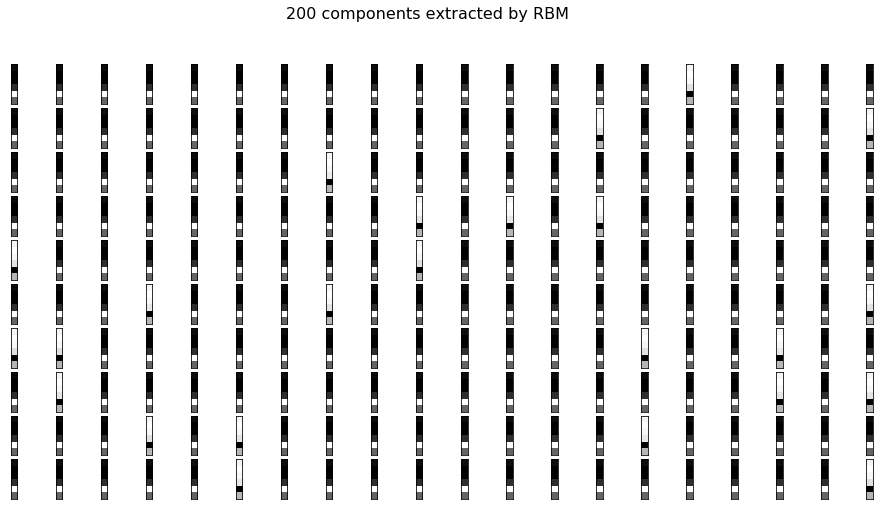

In [0]:
%matplotlib inline
weightmap_shape = (6,1)
fig,axes = plt.subplots(10,20, figsize=(16,8))
fig.suptitle('200 components extracted by RBM', fontsize=16)
fig.subplots_adjust(hspace = 0.1)
for i,ax in enumerate(axes.flatten()):
    
    ax.imshow(W[i].reshape(weightmap_shape),cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])


In [0]:
# Save hidden state biases and activations
# The activations are the latent features we need
np.save("/rbm_biases.npy",rbm.intercept_hidden_)
np.save("/rbmm_hidden.npy",rbm.transform(data))

In [0]:
# Run logistic regression on the transformed data, i.e the latent features

logrbm = linear_model.LogisticRegression(C=1.0)

h = rbm.transform(data)
logrbm.fit(h,trainy)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
print(classification_report(testy, logrbm.predict(rbm.transform(testx))))

              precision    recall  f1-score   support

         0.0       0.52      0.41      0.46        41
         1.0       0.49      0.59      0.53        39

    accuracy                           0.50        80
   macro avg       0.50      0.50      0.50        80
weighted avg       0.50      0.50      0.50        80



In [0]:
rbm_biases = np.load("/rbm_biases.npy")
rbm_weights = np.load("/rbm_weights.npy")

print(rbm_biases.shape, rbm_weights.shape)


(200,) (200, 6)


In [0]:
rbm_weight = rbm_weights.T
rbm_bias = rbm_biases

In [0]:
import tensorflow as tf

# variables for dimensions 
feature_size = 200
img_size = 6*1
num_classes = 2

x = tf.placeholder(tf.float32,[None, img_size])

# Placeholders for labels
y_true = tf.placeholder(tf.float32, [None,num_classes])
y_true_cls = tf.placeholder(tf.int64,[None])

# Connections between input layer and first hidden layer
# These will be initialised with RBM weights and biases

rbm_w = tf.Variable(rbm_weight.astype(np.float32))
rbm_b = tf.Variable(rbm_bias.astype(np.float32))
_h = tf.nn.relu(tf.matmul(x, rbm_w) + rbm_b)


# Connections from hidden layer to final output layer
weights = tf.Variable(tf.random_normal([feature_size, num_classes],stddev=0.35))
biases = tf.Variable(tf.zeros([num_classes]))

logits = tf.matmul(_h,weights) + biases
print(logits.shape)
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.Session()

sess.run(tf.global_variables_initializer())

In [0]:
batch_size = 32
mytrainy =  np.genfromtxt("/trainlabel.csv", delimiter=",")

def optimize(num_iterations):
    for i in range(num_iterations):
        train_x, train_y = trainx, mytrainy
        train_y=np.concatenate((train_y,mytrainy))
        train_y=np.reshape(train_y, (120, 2))
        print(train_y.shape)
        
        feed_dict_for_training = {x:train_x,
                                  y_true: train_y}
        
        
        sess.run(optimizer,feed_dict=feed_dict_for_training)
        

In [0]:
feed_dict_for_testing = { x: testx,
                          y_true_cls : testy}
print(testx.shape,testy.shape)
def get_accuracy():
    acc = sess.run(accuracy, feed_dict=feed_dict_for_testing)
    
    print("Accuracy on test-set: {0:.1%}".format(acc))

(80, 6) (80,)


In [0]:
get_accuracy()

Accuracy on test-set: 50.0%


In [0]:
optimize(num_iterations = 10)

(120, 2)
(120, 2)
(120, 2)
(120, 2)
(120, 2)
(120, 2)
(120, 2)
(120, 2)
(120, 2)
(120, 2)


In [0]:
get_accuracy()

Accuracy on test-set: 52.5%


In [0]:
optimize(num_iterations = 90)
get_accuracy()

In [0]:
optimize(num_iterations = 100)
get_accuracy()

In [0]:
optimize(num_iterations = 100)
get_accuracy()

In [0]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=6, name='rbm'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# set weights between input and hidden layer and hidden biases
layer = model.get_layer('rbm')
layer.set_weights([rbm_weight,rbm_bias])


# Train the model, iterating on the data in batches of 32 samples
model.fit(trainx, trainy, epochs=10, batch_size=32)

Epoch 1/10
120/120 [==============================] - 4s 35ms/step - loss: 8.4413 - acc: 0.4750
Epoch 2/10
120/120 [==============================] - 0s 134us/step - loss: 8.0648 - acc: 0.5000
Epoch 3/10
120/120 [==============================] - 0s 131us/step - loss: 8.0648 - acc: 0.5000
Epoch 4/10
120/120 [==============================] - 0s 111us/step - loss: 8.0648 - acc: 0.5000
Epoch 5/10
120/120 [==============================] - 0s 120us/step - loss: 8.0648 - acc: 0.5000
Epoch 6/10
120/120 [==============================] - 0s 102us/step - loss: 8.0647 - acc: 0.5000
Epoch 7/10
120/120 [==============================] - 0s 126us/step - loss: 8.0647 - acc: 0.5000
Epoch 8/10
120/120 [==============================] - 0s 111us/step - loss: 8.0647 - acc: 0.5000
Epoch 9/10
120/120 [==============================] - 0s 118us/step - loss: 8.0647 - acc: 0.5000
Epoch 10/10
120/120 [==============================] - 0s 103us/step - loss: 8.0647 - acc: 0.5000


In [0]:
#print(model.predict(testx))
print(classification_report(testy, np.argmax(model.predict(testx),axis=1)))

              precision    recall  f1-score   support

         0.0       1.00      0.02      0.05        41
         1.0       0.49      1.00      0.66        39

    accuracy                           0.50        80
   macro avg       0.75      0.51      0.35        80
weighted avg       0.75      0.50      0.35        80



In [0]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=6))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



model.fit(trainx, mytrainy, epochs=100, batch_size=32)

Epoch 1/100
120/120 [==============================] - 2s 20ms/step - loss: 0.9602 - acc: 0.5000
Epoch 2/100
120/120 [==============================] - 0s 105us/step - loss: 1.0052 - acc: 0.5750
Epoch 3/100
120/120 [==============================] - 0s 100us/step - loss: 1.0510 - acc: 0.4917
Epoch 4/100
120/120 [==============================] - 0s 101us/step - loss: 1.2048 - acc: 0.5750
Epoch 5/100
120/120 [==============================] - 0s 95us/step - loss: 1.1263 - acc: 0.5500
Epoch 6/100
120/120 [==============================] - 0s 104us/step - loss: 0.7996 - acc: 0.6000
Epoch 7/100
120/120 [==============================] - 0s 99us/step - loss: 0.8302 - acc: 0.5833
Epoch 8/100
120/120 [==============================] - 0s 99us/step - loss: 0.6899 - acc: 0.7250
Epoch 9/100
120/120 [==============================] - 0s 92us/step - loss: 0.6909 - acc: 0.6833
Epoch 10/100
120/120 [==============================] - 0s 92us/step - loss: 0.6272 - acc: 0.6917
Epoch 11/100
120/120 [===

In [0]:
print(classification_report(testy, np.argmax(model.predict(testx),axis=1)))

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.94        41
         1.0       0.90      0.97      0.94        39

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=6))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Generate dummy data
# Train the model, iterating on the data in batches of 32 samples
model.fit(trainx, mytrainy, epochs=100, batch_size=32)

Epoch 1/100
120/120 [==============================] - 3s 23ms/step - loss: 1.2477 - acc: 0.4750
Epoch 2/100
120/120 [==============================] - 0s 103us/step - loss: 1.2649 - acc: 0.5417
Epoch 3/100
120/120 [==============================] - 0s 105us/step - loss: 1.0197 - acc: 0.5500
Epoch 4/100
120/120 [==============================] - 0s 101us/step - loss: 0.8951 - acc: 0.6583
Epoch 5/100
120/120 [==============================] - 0s 111us/step - loss: 0.7654 - acc: 0.7000
Epoch 6/100
120/120 [==============================] - 0s 102us/step - loss: 0.9957 - acc: 0.5917
Epoch 7/100
120/120 [==============================] - 0s 100us/step - loss: 0.5925 - acc: 0.6833
Epoch 8/100
120/120 [==============================] - 0s 102us/step - loss: 0.9532 - acc: 0.6500
Epoch 9/100
120/120 [==============================] - 0s 88us/step - loss: 0.7054 - acc: 0.6500
Epoch 10/100
120/120 [==============================] - 0s 102us/step - loss: 0.7355 - acc: 0.6500
Epoch 11/100
120/120 

In [0]:
print(classification_report(testy, np.argmax(model.predict(testx),axis=1)))

              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90        41
         1.0       1.00      0.77      0.87        39

    accuracy                           0.89        80
   macro avg       0.91      0.88      0.89        80
weighted avg       0.91      0.89      0.89        80



In [0]:
#####DBN----
import numpy as np
from sklearn import linear_model, datasets
from sklearn.metrics import classification_report
from sklearn.neural_network import BernoulliRBM
from keras.models import Sequential
from keras.layers import Dense, Activation
import os
import json
import pickle

In [0]:
class DBN():

  def __init__(
    self,
    train_data,
    targets, 
    layers,
    outputs,
    rbm_lr,
    rbm_iters,
    rbm_dir=None,
    test_data = None,
    test_targets = None,    
    epochs = 100,
    fine_tune_batch_size = 32

     ):

    self.hidden_sizes = layers
    self.outputs = outputs
    self.targets = targets
    self.data = train_data

    if test_data is None:
      self.validate = False
    else:
      self.validate = True

    self.valid_data = test_data
    self.valid_labels = test_targets

    self.rbm_learning_rate = rbm_lr
    self.rbm_iters = rbm_iters

    self.epochs = epochs
    self.nn_batch_size = fine_tune_batch_size

    self.rbm_weights = []
    self.rbm_biases = []
    self.rbm_h_act = []

    self.model = None
    self.history = None

    
    logdir="/"


    self.outdir = "/"
    self.logdir=logdir

  def pretrain(self,save=True):
    
    visual_layer = self.data

    for i in range(len(self.hidden_sizes)):
      print("[DBN] Layer {} Pre-Training".format(i+1))

      rbm = BernoulliRBM(n_components = self.hidden_sizes[i], n_iter = self.rbm_iters[i], learning_rate = 0.0000000001,  verbose = True, batch_size = 32)
      grbm=GBRBM(n_visible=6, n_hidden=200, learning_rate=0.01)
      rbm.fit(visual_layer)
      self.rbm_weights.append(rbm.components_)
      self.rbm_biases.append(rbm.intercept_hidden_)
      self.rbm_h_act.append(rbm.transform(visual_layer))

      visual_layer = self.rbm_h_act[-1]

    if save:
      with open(self.outdir + "rbm_weights.p", 'wb') as f:
        pickle.dump(self.rbm_weights, f)

      with open(self.outdir + "rbm_biases.p", 'wb') as f:
        pickle.dump(self.rbm_biases, f)

      with open(self.outdir + "rbm_hidden.p", 'wb') as f:
        pickle.dump(self.rbm_h_act, f) 




  def finetune(self):
    model = Sequential()
    for i in range(len(self.hidden_sizes)):

      if i==0:
        model.add(Dense(self.hidden_sizes[i], activation='relu', input_dim=self.data.shape[1], name='rbm_{}'.format(i)))
      else:
        model.add(Dense(self.hidden_sizes[i], activation='relu', name='rbm_{}'.format(i)))


    model.add(Dense(self.outputs, activation='softmax'))
    model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    for i in range(len(self.hidden_sizes)):
      layer = model.get_layer('rbm_{}'.format(i))
      layer.set_weights([self.rbm_weights[i].transpose(),self.rbm_biases[i]])


    if self.validate:
      self.history = model.fit(trainx, trainy, 
                              epochs = self.epochs, 
                              batch_size = self.nn_batch_size,
                              validation_data=(self.valid_data, self.valid_labels)
                              )
    else:
       self.history = model.fit(trainx, trainy, 
                              epochs = self.epochs, 
                              batch_size = self.nn_batch_size
                            )     
    self.model = model

  def report(self, data, labels):
    print(classification_report((labels), np.argmax(self.model.predict(data),axis=1)))


  def save_model(self,filename):

    if self.model is None :
      raise ValueError("Run finetune() first")

    with open(self.outdir + filename, mode='w', encoding='utf-8') as outfile:

      data = {
              "model_config":self.model.get_config(),
              "loss_acc": self.history.history
          }
      json.dump(data, outfile, indent=2)

  def load_rbm(self):
    try:
      self.rbm_weights = pickle.load("/rbm_weights.p")
      self.rbm_biases = pickle.load("/rbm_biases.p")
      self.rbm_h_act = pickle.load("/rbm_hidden.p")
    except:
      print("No such file or directory.")



In [0]:
if __name__ == '__main__':

  trainx = np.genfromtxt("/trainafter.csv", delimiter=",")
  trainy=np.genfromtxt("/trainlabel.csv", delimiter=",")
  testx =np.genfromtxt("/test.csv", delimiter=",")
  testy = np.genfromtxt("/testlabel.csv", delimiter=",")

  dbn = DBN(train_data = trainx, targets = trainy,
            layers = [200],
            outputs = 2,
            rbm_iters = [100],
            rbm_lr = [0.01]
            )
  dbn.pretrain(save=True)
  dbn.finetune()
  #dbn.save_model("/bci_dbn_model.json")

 



[DBN] Layer 1 Pre-Training
[BernoulliRBM] Iteration 1, pseudo-likelihood = -14.62, time = 0.03s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -11.97, time = 0.07s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -14.31, time = 0.07s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -20.23, time = 0.07s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -12.59, time = 0.08s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -16.58, time = 0.07s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -16.82, time = 0.07s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -14.60, time = 0.07s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -18.62, time = 0.07s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -11.82, time = 0.07s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -15.04, time = 0.07s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -10.65, time = 0.07s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -14.37, time = 0.07s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -15.82, time = 0.07s
[B

In [0]:
  print("Training Report")
  dbn.report(trainx,trainy)
  

  #print((trainx),(trainy),(testx),(testy))
  print("Testing Report")
  dbn.report(testx,testy)

Training Report
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91        60
         1.0       0.90      0.92      0.91        60

    accuracy                           0.91       120
   macro avg       0.91      0.91      0.91       120
weighted avg       0.91      0.91      0.91       120

Testing Report
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92        41
         1.0       0.92      0.90      0.91        39

    accuracy                           0.91        80
   macro avg       0.91      0.91      0.91        80
weighted avg       0.91      0.91      0.91        80

